# Analisi di Annunci di Lavoro

Abbiamo un datraset di annunci di lavoro e vogliamo analizzarli per capire quali sono gli annunci fraudolenti e quali no. 

Per fare ciò, possiamo utilizzare tecniche di NLP per estrarre informazioni utili dai testi degli annunci e costruire un modello di classificazione che ci permetta di distinguere tra annunci fraudolenti e non fraudolenti.

## EDA

In [1]:
import pandas as pd

df = pd.read_csv("data/archive/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Dobbiamo capire come sono strutturati i dati e quali informazioni possiamo estrarre da essi.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Abbiamo quasi 18k righe e 18 colonne. 

La colonna `fraudulent` è la nostra variabile target, mentre le altre colonne contengono informazioni sui vari annunci.

Molte colonne sono di tipo testuale, quindi dovremo utilizzare tecniche di NLP per analizzarle.

### Data Cleaning

Cominciamo con vedere quanti valori nulli ci sono nel dataset.

In [3]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

I valori nulli sono presenti solo nelle colonne di testo.

'location',
'department',
'salary_range',
'company_profile',
'description',
'requirements',
'benefits',
'employment_type',
'required_experience',
'required_education',
'industry',
'function'

In [4]:
null_columns = df.columns[df.isnull().any()]
null_columns

Index(['location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function'],
      dtype='object')

In [5]:
#count distinct values in each column
for column in null_columns:
    print(column, df[column].nunique())

location 3105
department 1337
salary_range 874
company_profile 1709
description 14801
requirements 11967
benefits 6204
employment_type 5
required_experience 7
required_education 13
industry 131
function 37


Non tutte le colonne di testo devono essere trattate allo stesso modo. Ad esempio, la colonna `employment_type ` è una variabile categorica, mentre la colonna `description` è un testo libero. Dovranno essere riempite in modo diverso.

In [6]:
# For free-text columns, replace missing values with 'Missing'
text_columns = ['company_profile', 'description', 'requirements', 'benefits']
for column in text_columns:
    df[column] = df[column].fillna('Missing')

In [7]:
# For location and department columns, replace missing values with 'Unknown'
text_columns = ['location', 'department']
for column in text_columns:
    df[column] = df[column].fillna('Unknown')

In [8]:
# For other categorical columns, replace missing values with 'Not Specified'
text_columns = ['salary_range', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for column in text_columns:
    df[column] = df[column].fillna('Not Specified')

In [9]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [10]:
print("Fraudulent Value Counts:")
print(df['fraudulent'].value_counts().rename(index={0: 'Not Fraudulent', 1: 'Fraudulent'}).rename_axis('Fraudulent Value').reset_index(name='Counts'))

Fraudulent Value Counts:
  Fraudulent Value  Counts
0   Not Fraudulent   17014
1       Fraudulent     866


### Visualizzazione

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

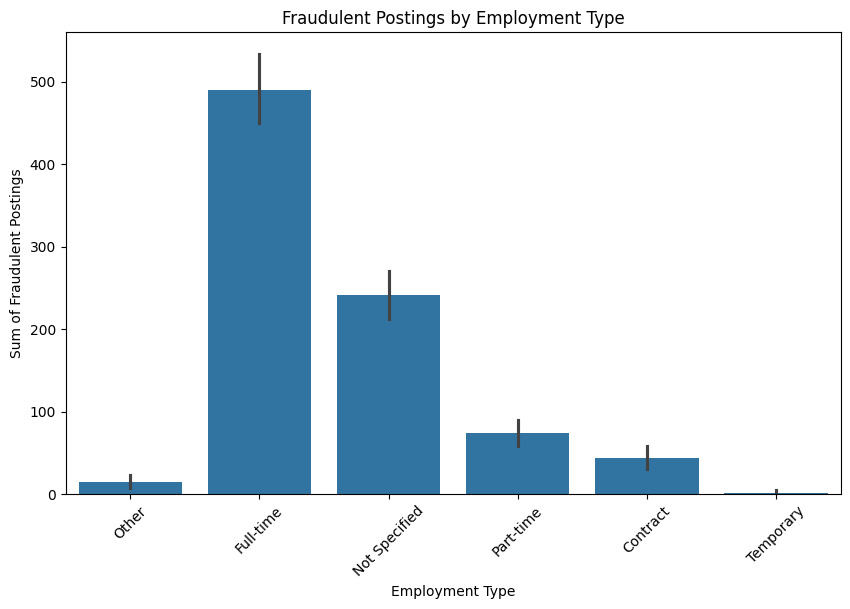

In [12]:
# Bar plot for employment_type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

La maggior parte degli annunci fraudolenti sono 'full-time', i meno sono 'Temporary'

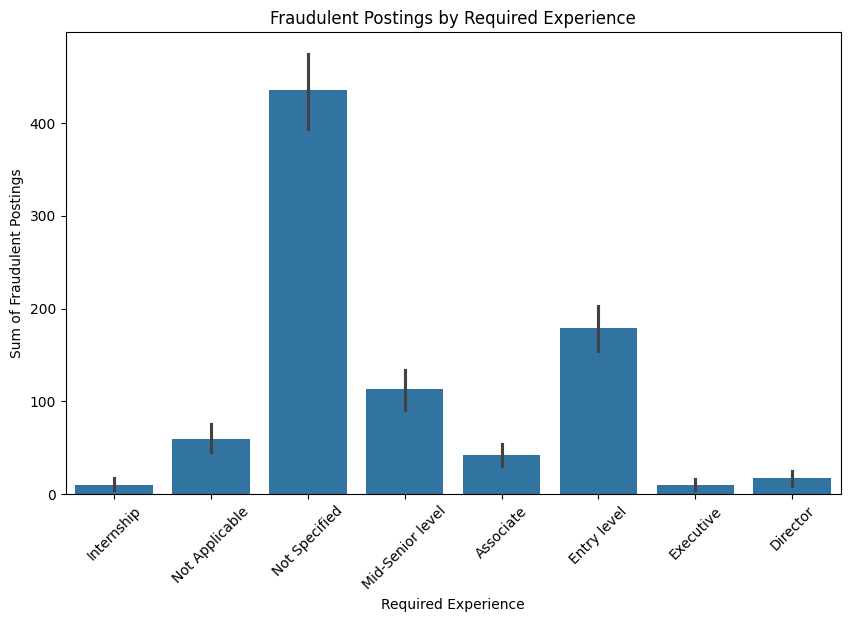

In [13]:
# Bar plot for required_experience
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

La maggior parte degli annunci fraudolenti non specificano l'esperienza richiesta, i meno sono con esperienza Executive e Internship

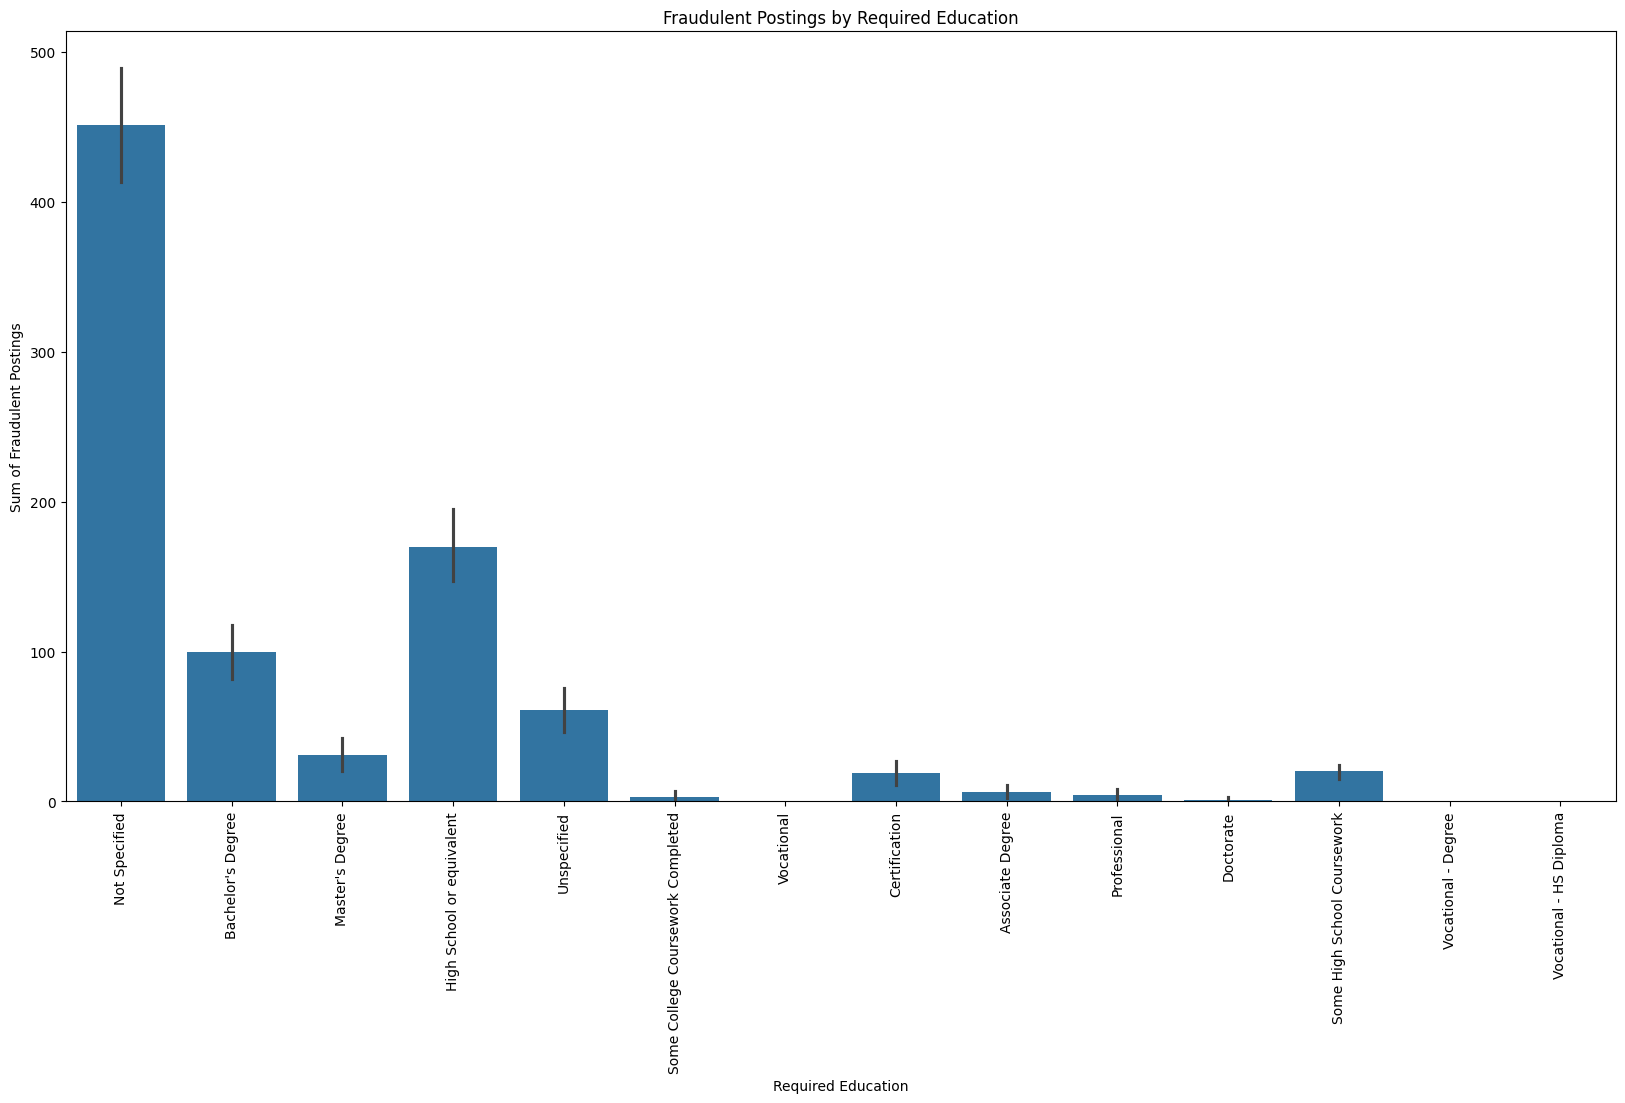

In [14]:
# Bar plot for required_education
plt.figure(figsize=(20, 10))
sns.barplot(data=df, x='required_education', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Education')
plt.xlabel('Required Education')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation = 90)
plt.show()

In Required Education, la possibilità di frode è maggiore per i lavori dove il livello è non specificato, mentre è minore per i lavori che richiedono varianti di Vocational o Doctorate.

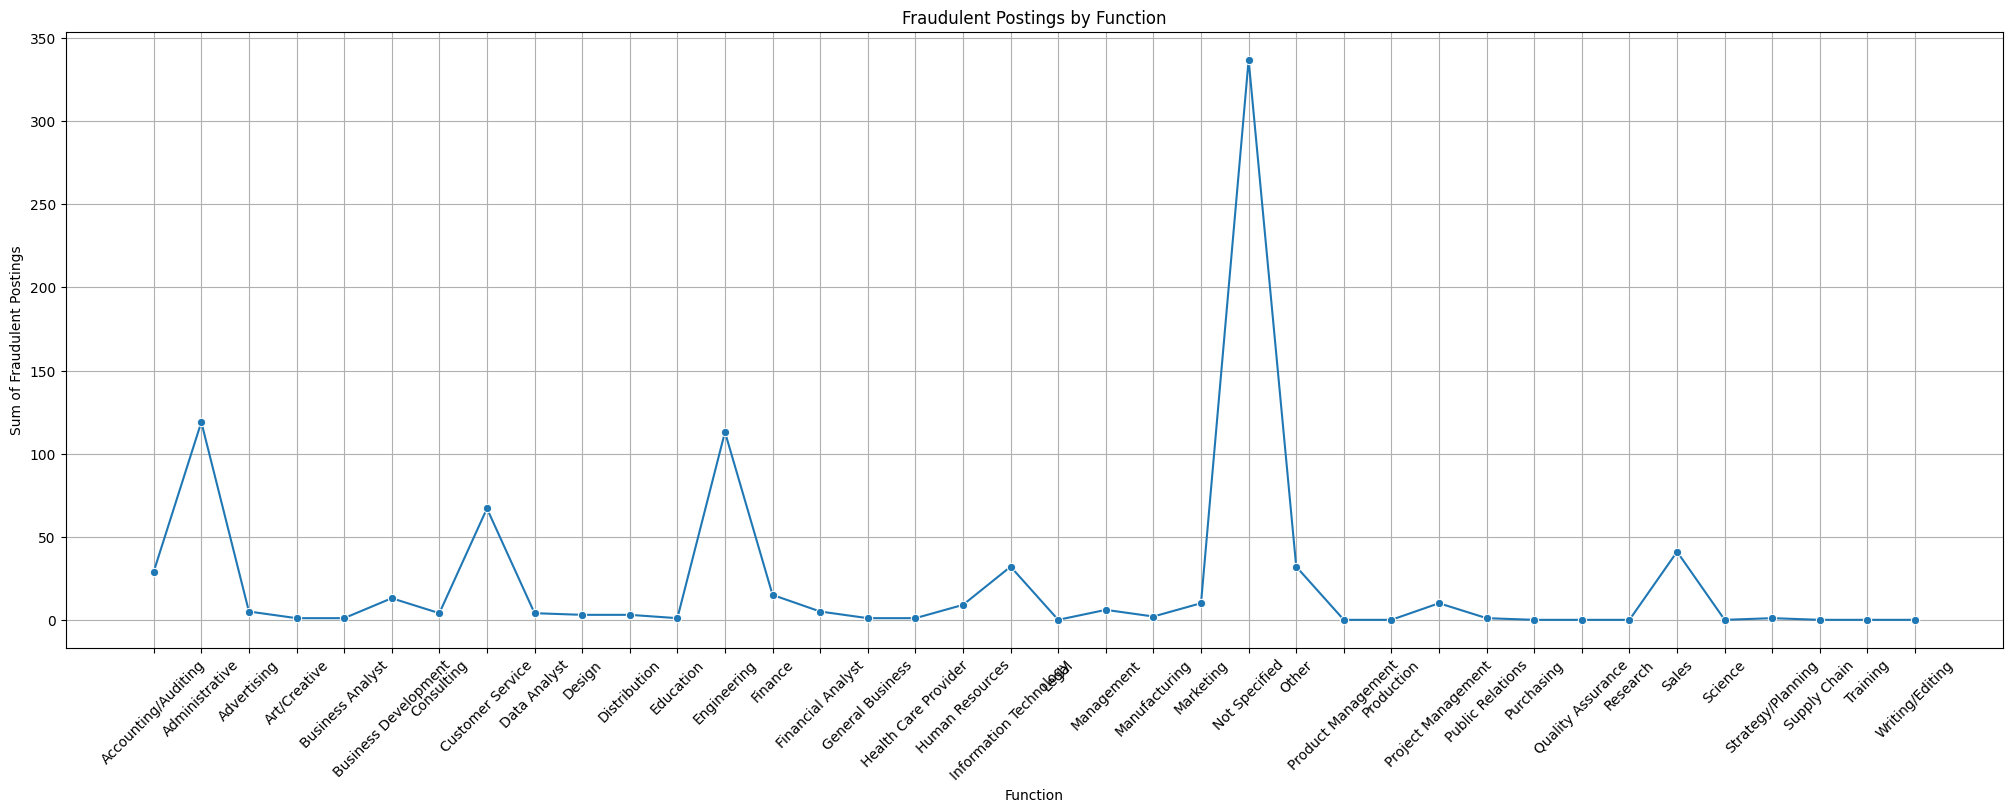

In [15]:
# Calculate the sum of fraudulent postings by function
fraudulent_summary = df.groupby('function')['fraudulent'].sum().reset_index()

plt.figure(figsize=(25, 8))
sns.lineplot(data=fraudulent_summary, x='function', y='fraudulent', marker='o')
plt.title('Fraudulent Postings by Function')
plt.xlabel('Function')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.grid(True) 
plt.show()



Gli annunci fraudolenti sono più comuni per funzioni quando il vaolre è 'Not Specified', seguito da Accounting ed Engineering.

## Preprocessing

Ci sono alcuni accorgimenti che possiamo fare per prepare i dati per l'analisi e la modellazione.

Uno di questi è la rimozione di caratteri speciali e numeri dai testi degli annunci, in modo da mantenere solo le parole.

Potremmo anche rimuovere le stopwords e le parole troppo comuni, in modo da ridurre il rumore nei dati (non lo faremo qui).

Per rimuovere i caratteri speciali e i numeri, possiamo utilizzare espressioni regolari.

Alcuni appunti su regex:
- `[a-zA-Z]` matcha tutti i caratteri alfabetici
- `[0-9]` matcha tutti i caratteri numerici
- `[^a-zA-Z0-9]` matcha tutti i caratteri **non** alfanumerici
- `+` matcha uno o più occorrenze del carattere precedente
- `*` matcha zero o più occorrenze del carattere precedente
- `\s` matcha uno spazio
- `\w` matcha un carattere alfanumerico o un underscore
- `\d` matcha un carattere numerico

In [16]:
import re

# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    return text

In [17]:
# Apply preprocessing to relevant text columns
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    df[col] = df[col].apply(preprocess_text)

## Modellazione

Per modellare i dati, possiamo utilizzare un modello di classificazione come Random Forest o Logistic Regression.

Dobbiamo anche considerare che il dataset è perlopiù testo. Quindi paragonabile ad un documento, e dobbiamo trasformarlo in un vettore di features numeriche. Per fare ciò, possiamo utilizzare tecniche di NLP come TF-IDF o Word2Vec.

Qui useremo TF-IDF per trasformare i testi in vettori numerici.

Alcuni appunti su TF-IDF:
- TF-IDF sta per Term Frequency-Inverse Document Frequency
- TF misura la frequenza di una parola in un documento
- IDF misura l'importanza di una parola in un corpus di documenti
- TF-IDF è il prodotto di TF e IDF
- TF-IDF assegna un punteggio a ciascuna parola in base alla sua frequenza nel documento e alla sua rarità nel corpus
- Le parole comuni ricevono un punteggio basso, mentre le parole rare ricevono un punteggio alto
- TF-IDF quindi è molto utile per estrarre informazioni rilevanti dai testi

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

In [19]:
# Vectorization
# Using TF-IDF for text vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [20]:
# Combine Text Features
df['combined_text'] = df[text_columns].agg(' '.join, axis=1)

In [21]:
# Train-Test Split
X = df['combined_text']  # Feature set
y = df['fraudulent']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Fit the vectorizer on training data and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Abbiamo anche probabilmente bisogno di gestire l'over-sampling dei dati, poiché la variabile target è sbilanciata.

Una tecnica comune per gestire l'over-sampling è SMOTE (Synthetic Minority Over-sampling Technique).

Alcuni appunti su SMOTE:
- SMOTE è una tecnica di over-sampling che crea campioni sintetici della classe minoritaria
- SMOTE funziona creando nuovi campioni che sono combinazioni lineari dei campioni esistenti
- SMOTE è molto utile per bilanciare i dati e migliorare le prestazioni del modello
- Tuttavia, SMOTE può anche introdurre rumore nei dati, quindi è importante utilizzarlo con cautela

In [23]:
class_distribution = pd.Series(y_train).value_counts(normalize=True)
print("Class Distribution before SMOTE:\n", class_distribution)

Class Distribution before SMOTE:
 fraudulent
0    0.951552
1    0.048448
Name: proportion, dtype: float64


***Decisamente sbilanciato*** - usiamo SMOTE per bilanciare le classi

In [24]:
%pip install imbalanced-learn

In [25]:
#use SMOTE
from imblearn.over_sampling import SMOTE

In [26]:
# Resampling: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

In [27]:
smote_class_distribution = pd.Series(y_smote).value_counts(normalize=True)
print("New Class Distribution after SMOTE:\n", smote_class_distribution)

New Class Distribution after SMOTE:
 fraudulent
0    0.5
1    0.5
Name: proportion, dtype: float64


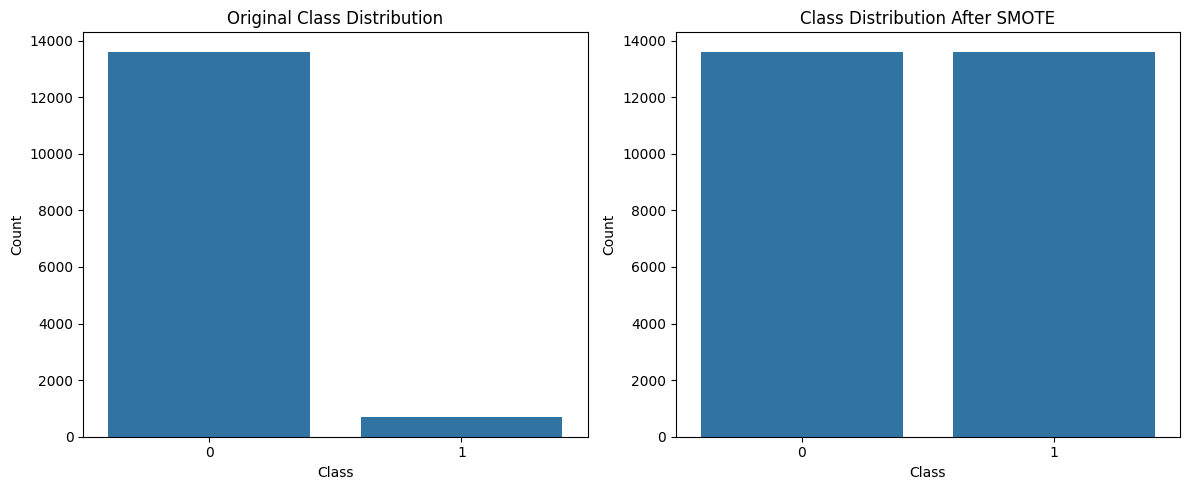

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [29]:
# Model Selection and Training
model = RandomForestClassifier(random_state=42)
model.fit(X_smote, y_smote) 

RandomForestClassifier(random_state=42)

### Valutazione del Modello (Tf-idf + SMOTE + Random Forest)

In [30]:
# Evaluation
y_pred = model.predict(X_test_tfidf)

In [31]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.65      0.79       173

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576



In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3403    0]
 [  60  113]]


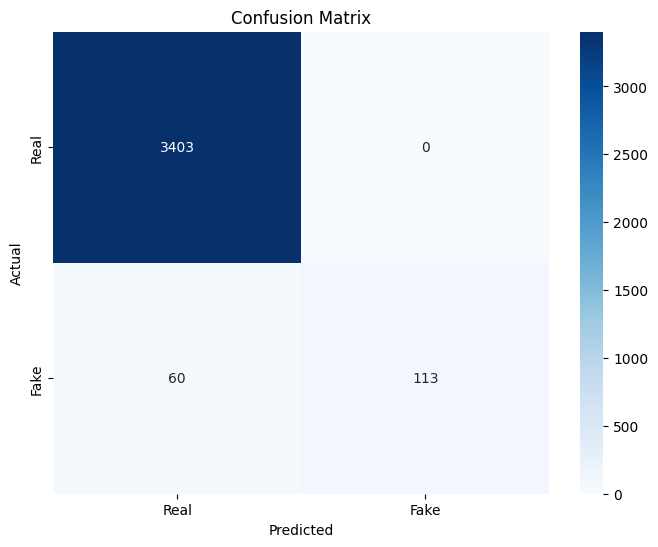

In [33]:
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Deep Learning: LSTM

Con un modello di Deep Learning possiamo ottenere risultati migliori rispetto ai modelli di Machine Learning tradizionali.

Ad esempio, possiamo utilizzare un modello di Deep Learning come LSTM (Long Short-Term Memory) per classificare gli annunci di lavoro.

Alcuni appunti su LSTM:
- LSTM è un tipo di RNN (Recurrent Neural Network) che è molto efficace nel lavorare con dati sequenziali come testi
- LSTM è in grado di catturare le dipendenze a lungo termine nei dati e di produrre previsioni accurate
- LSTM è composto da tre porte: input, output e forget gate
- LSTM è in grado di memorizzare le informazioni rilevanti e dimenticare le informazioni non rilevanti
- LSTM è molto utile per lavorare con dati sequenziali e produrre previsioni accurate

Per utilizzare LSTM con dati testuali, dobbiamo trasformare i testi in sequenze di token e poi passarli al modello LSTM.

Anche le nostre variabili target dovranno essere codificate in modo da poterle passare al modello LSTM.

In [34]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
df['fraudulent'] = le.fit_transform(df['fraudulent'])

In [35]:
# Combine text features into a single feature
# per reminder: text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df['combined_text'] = df[text_columns].agg(' '.join, axis=1)

In [36]:
# Train-Test Split
X = df['combined_text']  # Feature set
y = df['fraudulent']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
from imblearn.over_sampling import RandomOverSampler

# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

In [38]:
# Preprocessing the text data
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    return text

In [39]:
import numpy as np

X_resampled = np.array([preprocess_text(text[0]) for text in X_resampled])

### LSTM Model

In [41]:
%pip install --upgrade keras tensorflow

Note: you may need to restart the kernel to use updated packages.


Ok, è ora di costruire il modello LSTM.

Dobbiamo installare TensorFlow e Keras per costruire il modello.

TensorFlow è una libreria di Deep Learning molto popolare che ci permette di costruire modelli di Deep Learning in modo semplice e veloce.

Keras è una libreria di Deep Learning che si basa su TensorFlow (e altri).

#### Tokenization e Padding

Per utilizzare LSTM con dati testuali, dobbiamo trasformare i testi in sequenze di token e poi passarli al modello LSTM.

Per fare ciò, possiamo utilizzare la classe Tokenizer di Keras per tokenizzare i testi e la funzione pad_sequences per riempire le sequenze di token.

Alcuni appunti su Tokenization e Padding:
- Tokenization è il processo di trasformare i testi in sequenze di token
- Padding è il processo di riempimento delle sequenze di token in modo che abbiano la stessa lunghezza

In [47]:
# Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100  # Set the maximum length for padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_resampled)  # Ensure X_resampled is defined
X_sequences = tokenizer.texts_to_sequences(X_resampled)
X_padded = pad_sequences(X_sequences, maxlen=max_length)

#### Costruzione del Modello

Ora possiamo costruire il modello LSTM.

Il nostro modello LSTM sarà composto da diversi strati Embedding, LSTM, Dropout e Dense.

Alcuni appunti sul modello LSTM:
- Embedding è uno strato che mappa i token in vettori di embedding
- LSTM è uno strato che implementa l'architettura LSTM
- Dropout è uno strato che previene l'overfitting
- Dense è uno strato che implementa la classificazione
- Sequential è un tipo di modello in Keras che permette di costruire modelli sequenziali - cioè modelli con più strati da affrontare in sequenza (un po' come le pipeline in scikit-learn)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [49]:
# LSTM Model
def build_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=input_length))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))  # Adjust dropout rate
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### Addestramento del Modello con Callbacks

Ora possiamo addestrare il modello LSTM.

Per fare ciò, dobbiamo compilare il modello con un'ottimizzazione e una funzione di perdita, e poi addestrarlo con i dati di addestramento.

Possiamo anche utilizzare i callbacks per monitorare l'addestramento e salvare il modello.

Useremo callbacks come EarlyStopping, ReduceLROnPlateau, e ModelCheckpoint. Questi ci permettono di fermare l'addestramento se il modello smette di migliorare, ridurre il tasso di apprendimento se il modello si blocca, e salvare il modello migliore.

Passeremo i callbacks al metodo fit del modello per monitorare l'addestramento.

In [59]:
# Training LSTM Model with Callbacks
lstm_model = build_lstm_model(max_length)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

lstm_model.fit(X_padded, y_resampled, epochs=20, batch_size=32, validation_split=0.1,
                callbacks=[early_stopping, reduce_lr, model_checkpoint])

c:\Users\WilliamRussell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 88s 109ms/step - accuracy: 0.8796 - loss: 0.2732 - val_accuracy: 0.9934 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 2/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 141s 108ms/step - accuracy: 0.9936 - loss: 0.0201 - val_accuracy: 0.9934 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 3/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.9954 - loss: 0.0145 - val_accuracy: 0.9989 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 4/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.9966 - loss: 0.0111 - val_accuracy: 0.9989 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 109ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.9905 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 6/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.9915 - loss: 0.0285 - val_accuracy: 0.9974 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 7/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 145s 113ms/step - accuracy: 0

In [60]:
# Prepare Test Data for Prediction
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

In [61]:
# Evaluate Model
y_pred = lstm_model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [62]:
# Classification Report
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_classes))

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3403
           1       0.83      0.67      0.74       173

    accuracy                           0.98      3576
   macro avg       0.91      0.83      0.87      3576
weighted avg       0.98      0.98      0.98      3576



In [63]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3380   23]
 [  57  116]]


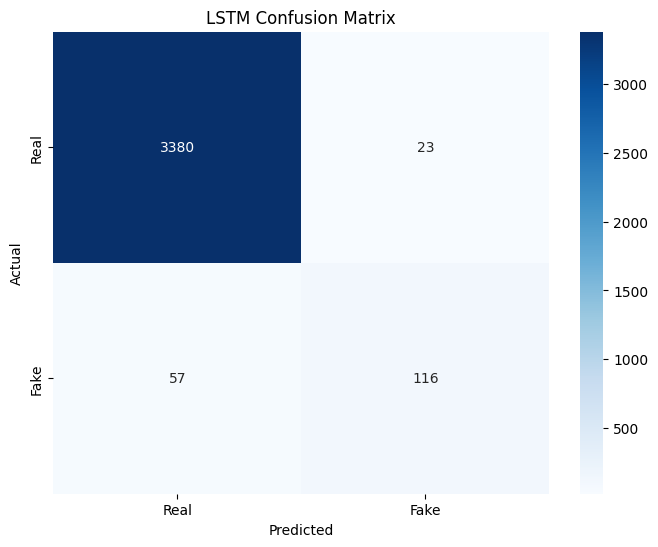

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('LSTM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Indubbiamente, c'è ancora spazio per migliorare la qualità del modello LSTM. Ad esempio, potremmo provare a regolare i parametri del modello, addestrare il modello su più epoche o utilizzare un modello più complesso. 

Inoltre, potremmo esplorare altre tecniche di pre-elaborazione del testo o di bilanciamento delle classi per migliorare le prestazioni del modello.

Così com'è, il modello Deep Learning sembra funzionare bene e produce risultati mediamente accurati, ma ci sono più falsi positivi e falsi negativi rispetto al modello tradizionale che ho creato usando TF-IDF + SMOTE + Random Forest.

> NOTE:
> Per informazioni su Deep Learning, puoi consultare il sito web di IBM su Deep Learning: [Deep Learning - IBM](https://www.ibm.com/topics/deep-learning)
>
> Per ulteriori info su LSTM, vedere [TensorFlow - Tutorials: text_classification_rnn](https://www.tensorflow.org/tutorials/text/text_classification_rnn) 
> e [Keras: LSTM](https://keras.io/api/layers/recurrent_layers/lstm/)
>
> Keras: https://keras.io/keras_hub/getting_started/